# Attenuated RHESSI example {[Download data files here](https://drive.google.com/file/d/1FMRVh8E0jCh3mj15r_Fy8g_RhbmlGIj-)}
This is looking at the M1 class flare observed by RHESSI from [Knuth+Glesener 2020](https://iopscience.iop.org/article/10.3847/1538-4357/abb779).
We perform spectroscopy on the interval where the thick attenuator is inserted.

## Potential modifications in the future could be:
- Auto-pick the SRM based on the counts spectrum flags (pain in the butt)
- ...

## Important points
- Systematic error is important to add to RHESSI data so that the minimizer has some wiggle room.

In [1]:
from sunxspex.sunxspex_fitting import fitter
from sunxspex.sunxspex_fitting import instruments

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
dat_fn = 'rhessi-data/rhessi-2011-jul-stixbins-spec.fits'
srm_fn = 'rhessi-data/rhessi-2011-jul-stixbins-srm.fits'

# keep this one cell so sys doesn't mess up
rl = instruments.RhessiLoader(pha_file=dat_fn, srm_file=srm_fn, srm_choice='both')

rl.start_event_time = '2011-07-30T02:08:04'
rl.end_event_time = '2011-07-30T02:09:00'

rl.end_background_time = '2011-07-30T01:56:00'
rl.start_background_time = '2011-07-30T01:54:00'

# shim-in systematic error
sys = 0.05
rl['count_error'] = np.sqrt(rl['count_error']**2 + (sys*rl['counts'])**2)
rl['count_rate_error'] = (rl['count_error'] / rl['counts']) * rl['count_rate']

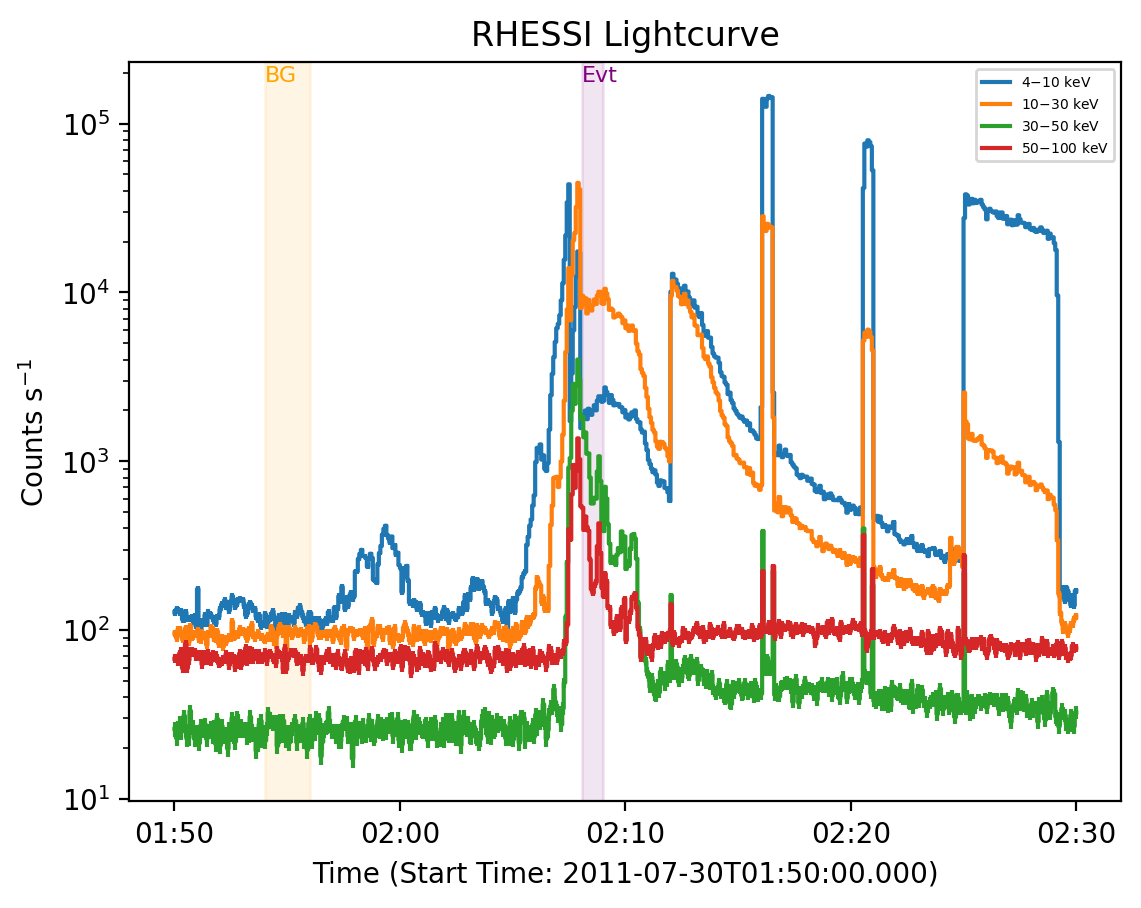

In [3]:
plt.figure()
_ = rl.lightcurve(energy_ranges=[[4, 10], [10, 30], [30, 50], [50, 100]])

In [4]:
ss = fitter.SunXspex(rl)
ss.energy_fitting_range = [5, 70]

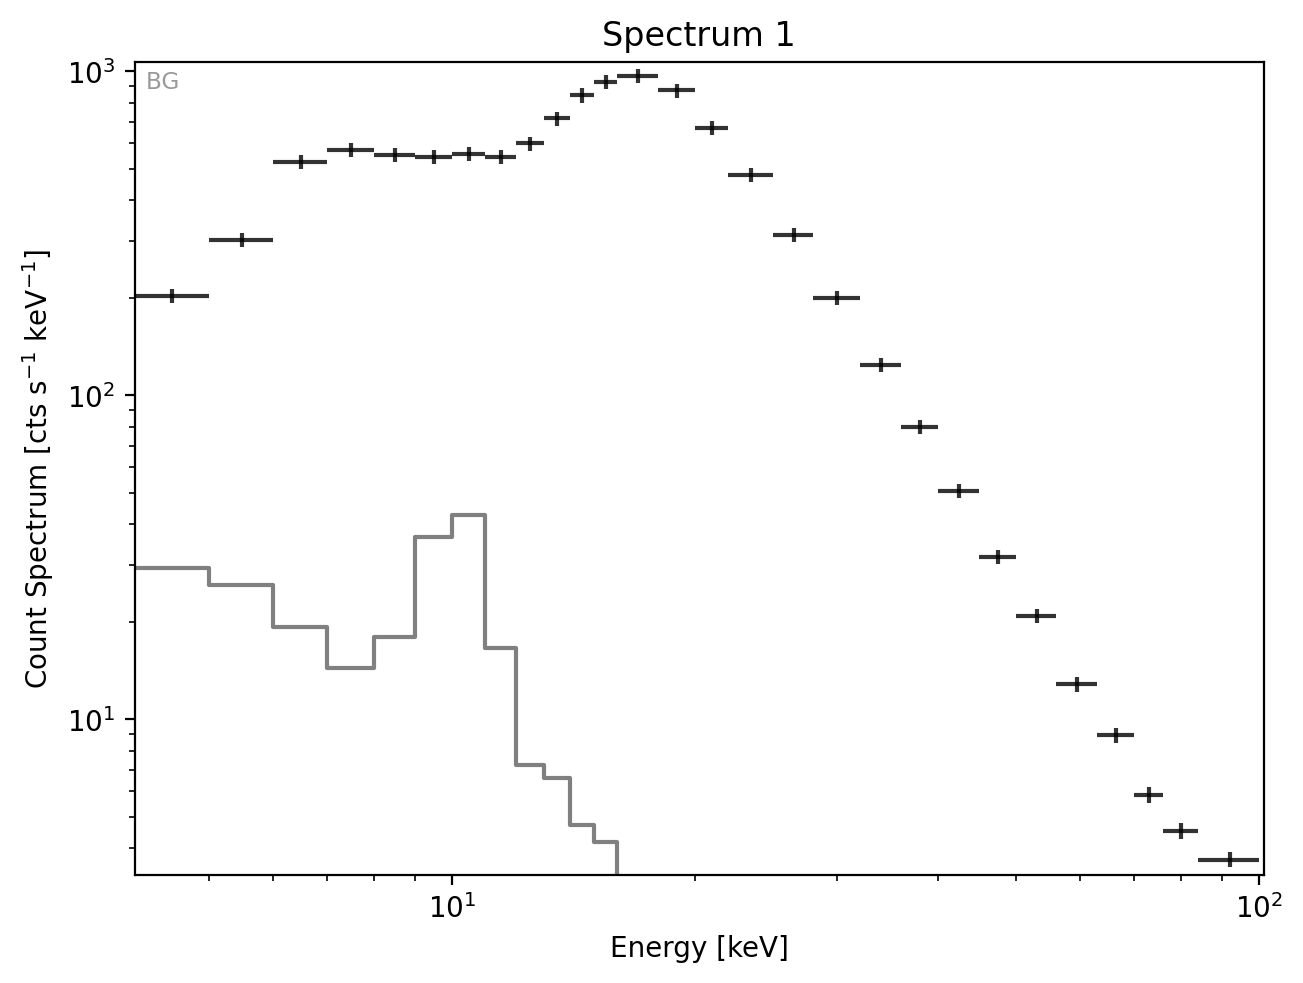

In [5]:
plt.figure(layout='constrained')
axs, *_ = ss.plot()
_ = axs[0].set(xscale='log')

In [6]:
def double_thick(electron_flux, low_index, break_energy, up_index, low_cutoff, up_cutoff, energies=None):
    from sunxspex.emission import bremsstrahlung_thick_target
    mids = np.mean(energies, axis=1)
    flux = bremsstrahlung_thick_target(
        photon_energies=mids,
        p=low_index,
        eebrk=break_energy,
        q=up_index,
        eelow=low_cutoff,
        eehigh=up_cutoff,
    )
    
    # scale to good units
    return 1e35 * electron_flux * flux

In [7]:
ss.add_photon_model(double_thick, overwrite=True)

2023-09-18T16:45:25Z INFO sunxspex.sunxspex_fitting.fitter 739: Model double_thick added.


In [8]:
ss.loglikelihood = 'chi2'
ss.model = 'f_vth + double_thick'

In [9]:
th_params = [
    'T1_spectrum1',
    'EM1_spectrum1',
]
nth_params = [
    'electron_flux1_spectrum1',
    'low_index1_spectrum1',
    'up_index1_spectrum1',
    'break_energy1_spectrum1',
    'low_cutoff1_spectrum1',
    'up_cutoff1_spectrum1',
]

In [10]:
ss.params['T1_spectrum1'] = ['free', 20, (5, 100)]
ss.params['EM1_spectrum1'] = ['free', 5000, (500, 100000)]

ss.params['electron_flux1_spectrum1'] = ['free', 10, (1, 50)]
ss.params['low_index1_spectrum1'] = ['free', 5, (1, 20)]
ss.params['up_index1_spectrum1'] = ['free', 5, (1, 20)]

ss.params['break_energy1_spectrum1'] = ['free', 40, (40, 100)]
ss.params['low_cutoff1_spectrum1'] = ['free', 20, (5, 39)]
ss.params['up_cutoff1_spectrum1'] = ['frozen', 500, (5, 1000)]

In [11]:
for p in th_params:
    ss.params[p] = 'free'
for p in nth_params:
    ss.params[p] = 'frozen'

In [12]:
_ = ss.fit()

In [13]:
for p in th_params:
    ss.params[p] = 'frozen'
for p in nth_params:
    ss.params[p] = 'free'

In [14]:
_ = ss.fit()

In [15]:
for p in th_params + nth_params:
    ss.params[p] = 'free'

In [16]:
_ = ss.fit()

[None]

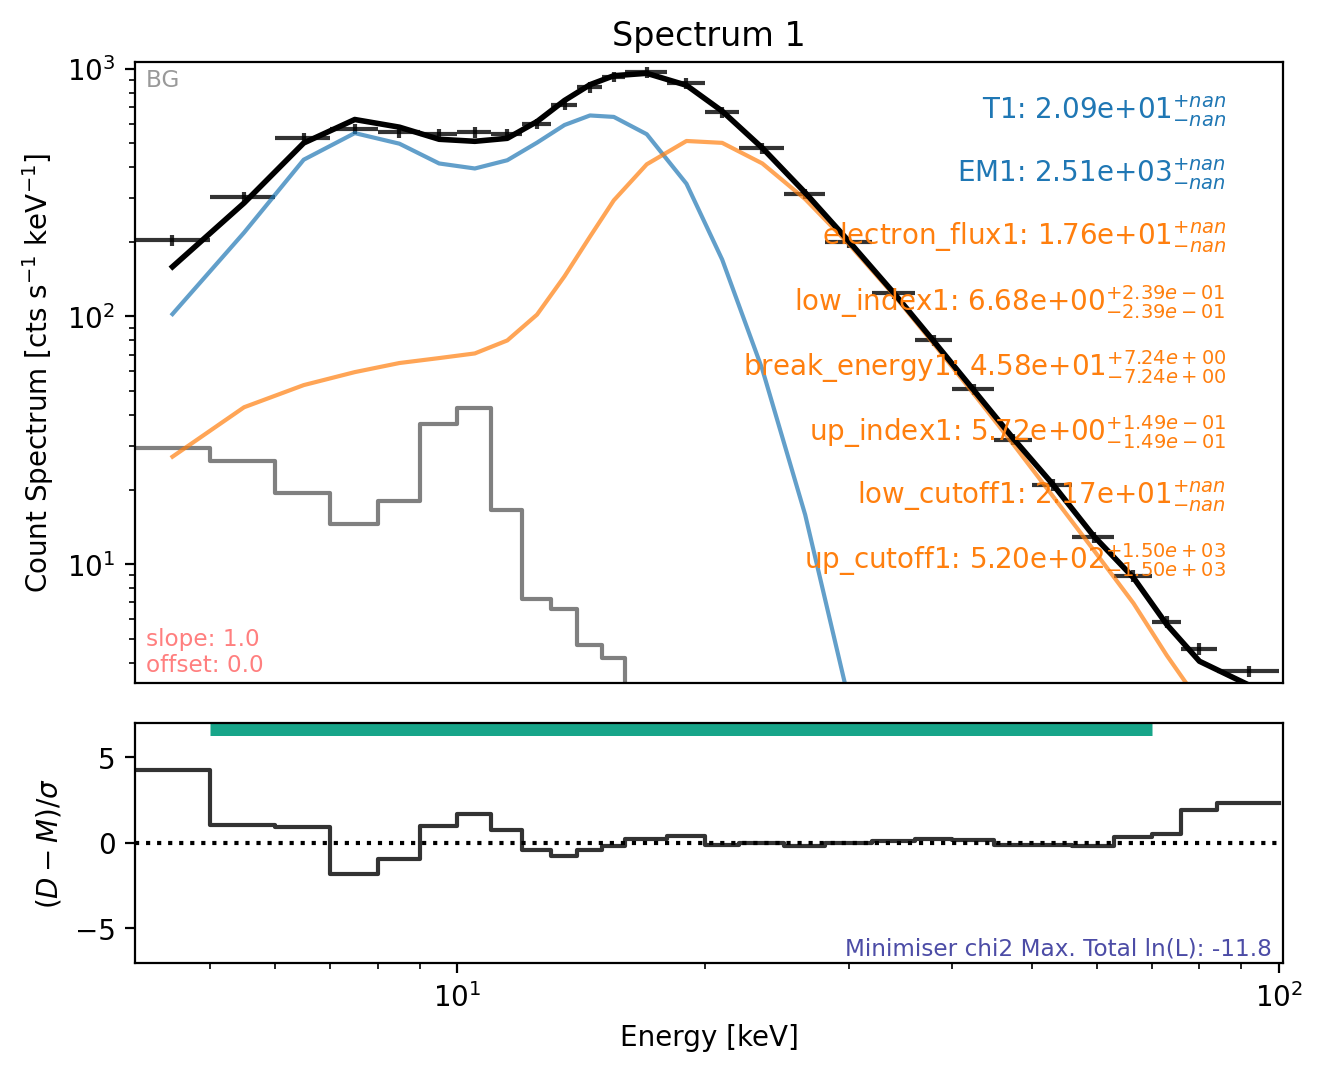

In [17]:
plt.figure(layout='constrained')
ss.plot()
plt.gca().set(xscale='log')

# Run MCMC if you want